# KC model demo for 3D modeling


This notebook demonstrates the python code for the SSC model and fit of the Kennel & Coroniti MHD model for the Crab nebula.

In [1]:
import sys
sys.path.append("/Users/manuelmeyer/Python/crabmeyerpy/")
sys.path.append("/Users/manuelmeyer/Python/fast_interp/")

In [2]:
from crabmeyerpy.ssc import kpc2cm, m_e_eV, arcmin2rad, eV2erg, eV2Hz, CrabSSC
from crabmeyerpy.ssc_3d import CrabSSC3D
from crabmeyerpy.electrondensity import nel_crab, nel_crab_extension, nel_crab_radio, nel_crab_radio_cutoff
from crabmeyerpy.electrondensity import gamma_max_kc, nel_wind_kc, B_kc, vz_sq
from crabmeyerpy.photonfields import black_body
from crabmeyerpy.data import CrabData
from scipy.integrate import simps
import matplotlib.pyplot as plt
import numpy as np
import logging
import copy
import astropy.constants as c
import astropy.units as u
import time
from astropy import constants

In [3]:
%load_ext autoreload
%autoreload 2

# Load 1D model

For comparison purposes we initialize the 1D model.

In [4]:
# the config for the 1D model
config_1d = {
    # electron spectrum parameters
    "params_n_el": {
        "Nradio": np.exp(120.),
        "gradio_min": np.exp(3.1),
        "gradio_max": np.exp(12.1),
        "Sradio": -1.60,
        "Nwind": np.exp(78.6),
        "gmin": np.exp(3.1),
        "gmax": np.exp(30.),
        "gwind_min": np.exp(12.96),
        "gwind_max": np.exp(22.51),
        "gwind_b": 1. / np.exp(19.5),
        "Swind": -3.23,
        "Sbreak": -0.53, 
        "sup_wind": 2.8,
    },
    # seed photon field parameters
    "params_n_seed": {
        "dust_T": 97.6,
        "dust_norm": 1.06e-13 / 8.11e-06,  # for new dust function
        "dust_extension": 1.3,
        "ic_sync": True, 
        "ic_dust": True,
        "ic_cmb": True
    }
}

In [5]:
#The magnetic field strength and the distance to the nebula
B = 124e-6  # B Field in G
d = 2.  # distance to nebula in kpc

In [6]:
# intitialize the model
ssc_1d = CrabSSC(copy.deepcopy(config_1d), nel_crab, B=B, d=d)

In [7]:
# compute the sync, dust, and IC components
# synchtron and dust component
nu_s_1d = np.logspace(7.,25.,200)  # Frequency in Hz
F_nu_sync_1d = ssc_1d.sync(nu_s_1d)
F_nu_dust_1d = ssc_1d.grey_body(nu_s_1d)

# IC component
nu_ic_1d = np.logspace(20.,30.,100)  # Frequency in Hz
F_nu_IC_1d = ssc_1d.ic(nu_ic_1d, g_steps=100, e_steps=50)

/Users/manuelmeyer/Python/crabmeyerpy/crabmeyerpy/photonfields.py:22: RuntimeWarning: overflow encountered in exp
  result = np.exp(kx) - 1.


Text(0, 0.5, '$\\nu L_\\nu\\,(\\mathrm{erg}\\,\\mathrm{s}^{-1}$)')

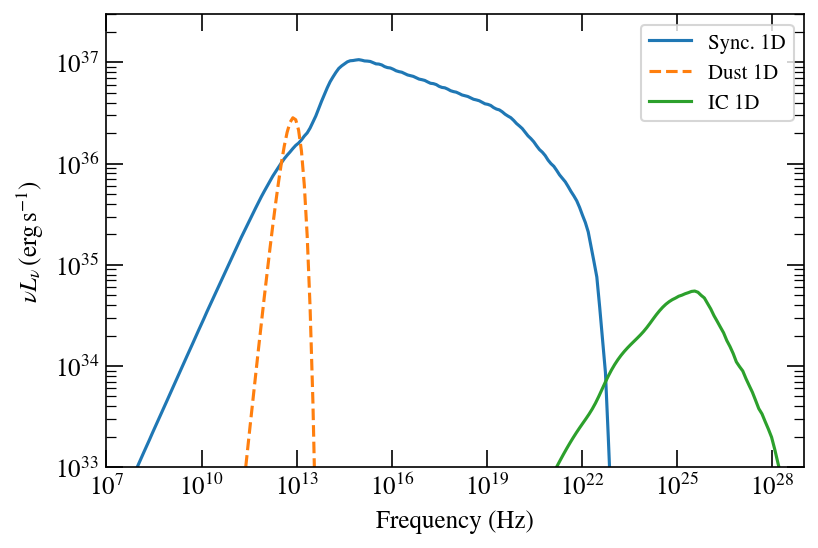

In [8]:
# plot function to plot 1d model output
def plot_1d(luminosity=True, ic=True, sync=True, dust=True, dpi=150, fig=None):
    if fig is None:
        plt.figure(dpi=dpi)
    if luminosity:
        c = 4. * np.pi * (d * kpc2cm)**2
    else:
        c = 1.

    if sync:
        plt.loglog(nu_s_1d, F_nu_sync_1d * nu_s_1d * c, ls='-', label="Sync. 1D")
    if dust:
        plt.loglog(nu_s_1d, F_nu_dust_1d * nu_s_1d * c, ls='--', label="Dust 1D")
    if ic:
        plt.loglog(nu_ic_1d, F_nu_IC_1d * nu_ic_1d * c, ls='-', label="IC 1D")

plot_1d()
plt.gca().set_ylim(1e33,3e37)
plt.gca().set_xlim(1e7,1e29)
plt.legend()
plt.xlabel("Frequency (Hz)")
plt.ylabel(r"$\nu L_\nu\,(\mathrm{erg}\,\mathrm{s}^{-1}$)")

# 3D KC model

Next we initialize the 3D model

In [9]:
config = {
    # electron spectrum parameters
    "sigma": 0.0045,
    "r_shock": 0.14 * u.pc.to('cm'),
    "spin_down_lumi": 5.e38,
    "Nradio": np.exp(-11.41) * 1.3, # these are just some scalings
    "gradio_min": np.exp(0.),
    "gradio_max": np.exp(13.55),
    "Sradio": -1.58,
    "Nwind": np.exp(-1.32) * 1.3, 
    "gwind_min": np.exp(13.94),
    "gwind_max": np.exp(22.6),
    "gmin": 1.,
    "gmax": 1e15,
    "Swind": -2.32,
    "dust_T": 97.6,
    "dust_norm": 1.0e-11  / (0.001 * kpc2cm)**3 / 4. / np.pi,  # for new dust function
    "dust_extension": 1.3,  # extension of nebula in FIR from dust
}

# these would have to be linked in a fit

print("E* : {0:.3e} GeV".format(config['gradio_max'] * m_e_eV / 1e9))
print("E0 : {0:.3e} GeV".format(config['gwind_min'] * m_e_eV / 1e9))
print("E_cut : {0:.3e} PeV".format(config['gwind_max'] * m_e_eV / 1e15))

E* : 3.918e+02 GeV
E0 : 5.787e+02 GeV
E_cut : 3.338e+00 PeV


In [10]:
# maximum radius of nebula
# this comes from Aharonian and Atoyan 1996 and should probably be updated
r0_pc = 1.8

In [11]:
# the assumed electron spectrum
def n_el_spec(gamma, r, **params):
    return nel_crab_radio_cutoff(gamma, **params) + nel_wind_kc(gamma, r, **params)

In [12]:
ssc = CrabSSC3D(copy.deepcopy(config), n_el_spec, B_kc, d_kpc=d, r0_pc=r0_pc, log_level="DEBUG")

In [13]:
# change dust extension to size of whole nebula
ssc.parameters['dust_extension'] = np.tan(ssc.r0 / ssc.d) / arcmin2rad
print(ssc.parameters['dust_extension'])

# and set it to constant
# as in Aharonian and Atoyan 1996
ssc.dust_radial_dependence = 'shell'

ssc.parameters['min_dust_extension'] = 0.

# decrease dust norm
ssc.parameters['dust_norm'] = 5e-12

3.0939729290791815


## plot the electron density at different radii

In [14]:
r = np.linspace(ssc.parameters['r_shock'], ssc.r0, 21)
r_int = np.linspace(ssc.parameters['r_shock'], ssc.r0, 100)
gamma = np.logspace(0., 12., 200)
gamma_int = np.logspace(0., 12., 300)

gg, rr = np.meshgrid(gamma, r, indexing='ij')
gg_int, rr_int = np.meshgrid(gamma_int, r_int, indexing='ij')

zz = rr / ssc.parameters['r_shock']
gm = gamma_max_kc(zz, **ssc.parameters)
vzz = vz_sq(zz, ssc.parameters['sigma'])

g_prime = gg * np.power(vzz, 1. / 3.) / (1. - gg / gm)

Text(0, 0.5, '$ mc^2 \\gamma^2 dn/d\\gamma $ (eV cm$^{-3}$)')

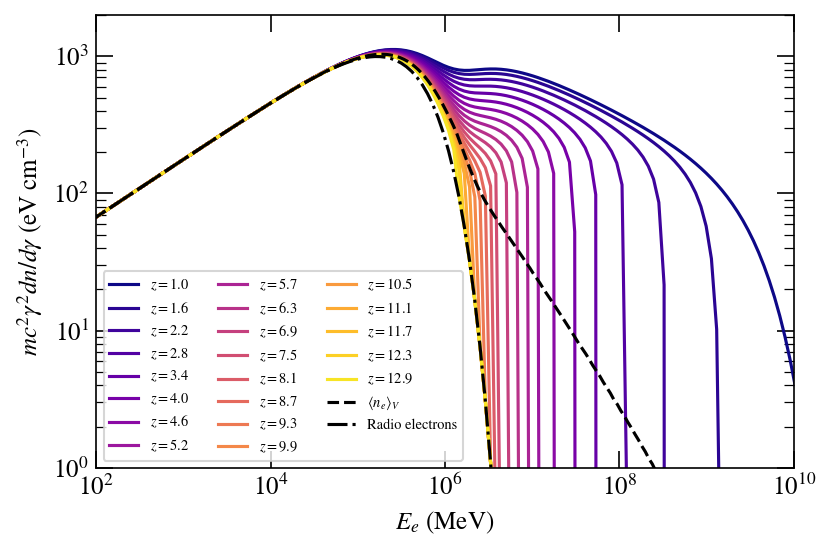

In [15]:
plt.figure(dpi=150)

c = gamma**2. * m_e_eV
c_int = gamma_int**2. * m_e_eV

# compute n_el over grid of gamma and r
n_el = ssc.n_el(gg, rr, **ssc.parameters)
n_el_int = ssc.n_el(gg_int, rr_int, **ssc.parameters)

# compute volume averaged n_el
V0 = 4. / 3. * np.pi * ssc.r0 ** 3.
n_el_avg = 4. * np.pi * simps(n_el_int * rr_int ** 2., rr_int) / V0

for i, ri in enumerate(r):
    plt.loglog(gamma * m_e_eV / 1e6, n_el[:,i] * c,
               color=plt.cm.plasma(i/r.size),
               label='$z={0:.1f}$'.format(ri / ssc.parameters['r_shock'])
              )

# volume averaged
plt.loglog(gamma_int * m_e_eV / 1e6, n_el_avg * c_int, ls='--', color='k',  label=r'$\langle n_e \rangle_V$')

# radio electrons
plt.loglog(gamma * m_e_eV / 1e6,
           nel_crab_radio_cutoff(gamma, **ssc.parameters) * c,
           ls='-.', color='k',  label=r'Radio electrons')

plt.legend(fontsize='x-small', ncol=3, loc=3)
v = plt.gca().get_ylim()
plt.ylim(1., 2e3)
plt.xlim(1e2,1e10)
plt.xlabel("$E_e$ (MeV)")
plt.ylabel("$ mc^2 \gamma^2 dn/d\gamma $ (eV cm$^{-3}$)")

Text(0.5, 0, '$z = r/r_s$')

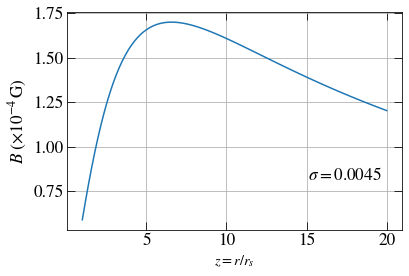

In [16]:
z = np.linspace(1.,20.,100)
plt.plot(z, B_kc(z * ssc.parameters['r_shock'], **ssc.parameters) * 1e4)
plt.annotate(r"$\sigma = {0:.4f}$".format(ssc.parameters['sigma']),
             xy=(0.72, 0.23), xycoords='axes fraction',
             fontsize='xx-large'
            )
plt.grid()
plt.gca().tick_params(labelsize='xx-large')
plt.ylabel(r"$B~(\times 10^{-4}\,\mathrm{G})$", fontsize='xx-large')
plt.xlabel(r"$z = r/r_s$", fontsize='x-large')


## Calculate the Synchrotron and Dust emissivities

Cacluate the volume emissivity $j_\nu^\mathrm{sync}(\nu, r)$ in units of $\mathrm{erg}\,\mathrm{s}^{-1}\,\mathrm{cm}^{-3}\,\mathrm{sr}^{-1}$.
From it, you can calculate the the luminosity as a volume integral, as well as the specific intensity as a l.o.s. integral. 
From the specific intensity, you get the flux by integrating over solid angle.

In [17]:
nu = np.logspace(7.,25.,100)
nn, rr = np.meshgrid(nu, r, indexing='ij')

In [18]:
j_nu_sync = ssc.j_sync(nu, r, g_axis=2, g_steps=151)
print(j_nu_sync.shape)

(100, 21)


Cacluate the volume emissivity $j_\nu^\mathrm{dust}(\nu, r)$ in units of $\mathrm{erg}\,\mathrm{s}^{-1}\,\mathrm{cm}^{-3}\,\mathrm{sr}^{-1}$

In [19]:
j_nu_dust = ssc.j_grey_body(nu, r)
print(j_nu_dust.shape)

/Users/manuelmeyer/Python/crabmeyerpy/crabmeyerpy/photonfields.py:22: RuntimeWarning: overflow encountered in exp
  result = np.exp(kx) - 1.
 ssc_3d.py: 513 --- DEBUG: Black body calculation in grey body function took 0.001s
 ssc_3d.py: 547 --- DEBUG: extension calculation in grey body function took 0.000s


(100, 21)


Plot the volume emissivity

(1e-27, 1e-17)

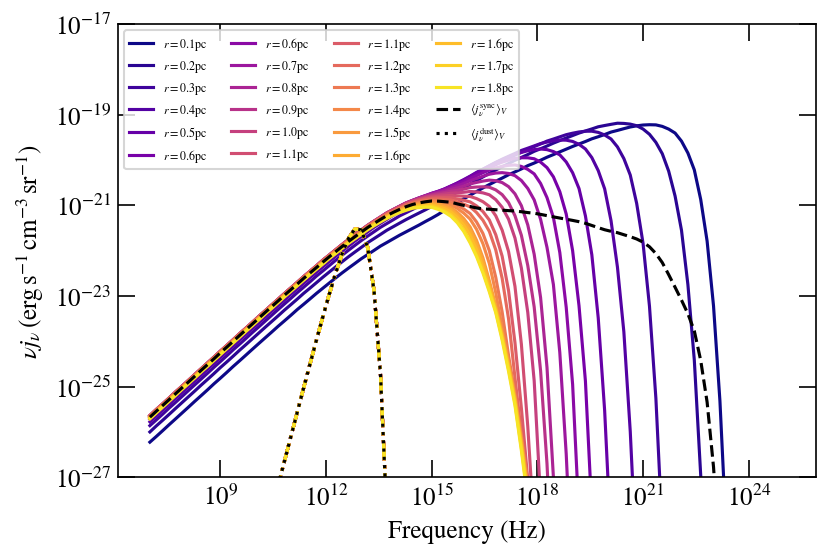

In [20]:
plt.figure(dpi=150)

for i, ri in enumerate(r):
    plt.loglog(nu, j_nu_sync[:,i] * nu,
               color=plt.cm.plasma(i/r.size),
               label='$r={0:.1f}$pc'.format(ri / kpc2cm * 1e3)
              )
    plt.loglog(nu, j_nu_dust[:,i] * nu,
               color=plt.cm.plasma(i/r.size),
               ls='-.'
              )
    
# compute volume averaged n_el
V0 = 4. / 3. * np.pi * ssc.r0 ** 3.
j_nu_sync_avg = 4. * np.pi * simps(j_nu_sync * rr ** 2., rr) / V0
j_nu_dust_avg = 4. * np.pi * simps(j_nu_dust * rr ** 2., rr) / V0

plt.loglog(nu, j_nu_sync_avg * nu,
           color='k',
           ls='--',
           label=r'$\langle j_\nu^\mathrm{sync} \rangle_V$'
           )

plt.loglog(nu, j_nu_dust_avg * nu,
           color='k',
           ls=':',
           label=r'$\langle j_\nu^\mathrm{dust} \rangle_V$'
           )

plt.legend(fontsize='xx-small', ncol=4, loc=2)
plt.xlabel("Frequency (Hz)")
plt.ylabel(r"$\nu j_\nu\,(\mathrm{erg}\,\mathrm{s}^{-1}\,\mathrm{cm}^{-3}\,\mathrm{sr}^{-1}$)")
plt.ylim(1e-27, 1e-17)

Calculate and plot the luminosity

In [21]:
# one factor of 4 pi from volume integral, second one from integral over 
# the solid angle. Each volume element emits isotropically.
L_nu_sync = simps(j_nu_sync * rr **2., rr, axis=1) * 4. * np.pi * 4. * np.pi
L_nu_dust = simps(j_nu_dust * rr **2., rr, axis=1) * 4. * np.pi * 4. * np.pi

(1e+33, 1e+38)

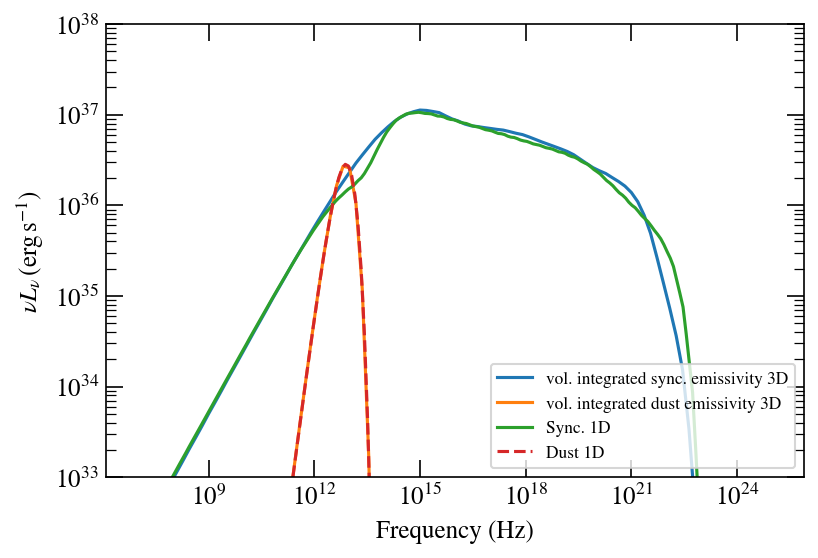

In [22]:
fig = plt.figure(dpi=150)
plt.loglog(nu, nu * L_nu_sync, label="vol. integrated sync. emissivity 3D")
plt.loglog(nu, nu * L_nu_dust, label="vol. integrated dust emissivity 3D")

# plot the 1D spectrum for comparison
plot_1d(fig=fig, ic=False)
plt.legend(fontsize='small')
plt.xlabel("Frequency (Hz)")
plt.ylabel(r"$\nu L_\nu\,(\mathrm{erg}\,\mathrm{s}^{-1}$)")
plt.ylim(1e33, 1e38)

### Calculate the spectral intensity and flux

From radiation transport and neglecting absorption, the spectral intensity is given by the integral

$$ I_\nu(\theta) = \int_0^{s_\max} j_\nu(s) ds, $$ 

which depends on $\theta$, the angular separation between the nebula center and the line of sight.
To compute it efficiently, we first interpolate the synchrotron volume emissivity.

#### Flux calculation

Once we have obtained $ I_\nu(\theta) $, we can calulate the flux $F_\nu$ that is emitted into a solid angle $\Omega$ 
from a point on the surface of the nebula. This follows the standard calculation of, e.g., calculating the received flux from a resolved stellar disk, i.e., the flux emitted into $[0, \theta]$ is

$$F_\nu = \int I_\nu \cos\theta d\Omega = 2\pi\int_0^\theta I_\nu\cos\theta'\sin\theta' d\theta' $$

In [23]:
ssc.use_fast_interp = True  # use a 2D interpolation routine using numba
ssc.interp_sync_init(r_min=ssc.parameters['r_shock'],r_max= ssc.r0,  r_steps=100)

In [24]:
I_nu_sync, theta_arcmin, _ = ssc.intensity2(nu, theta=100, r_min=ssc.parameters['r_shock'], integration_mode='romb')

/Users/manuelmeyer/anaconda3/envs/gammaALPs/lib/python3.8/site-packages/numba/core/ir_utils.py:2031: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'a' of function '_interp2d_k1'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../fast_interp/fast_interp/fast_interp.py", line 329:
@numba.njit(parallel=True)
def _interp2d_k1(f, xout, yout, fout, a, h, n, p, o, lb, ub):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))
/Users/manuelmeyer/anaconda3/envs/gammaALPs/lib/python3.8/site-packages/numba/core/ir_utils.py:2031: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'h' of function '_interp2d_k1'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.

In [25]:
I_nu_dust, _, _ = ssc.intensity2(nu, theta=100, which='dust')

 ssc_3d.py: 513 --- DEBUG: Black body calculation in grey body function took 0.016s
 ssc_3d.py: 547 --- DEBUG: extension calculation in grey body function took 0.006s


Text(0, 0.5, '$\\nu I_\\nu\\,(\\mathrm{erg}\\,\\mathrm{s}^{-1}\\,\\mathrm{cm}^{-2}\\,\\mathrm{sr}^{-1}$)')

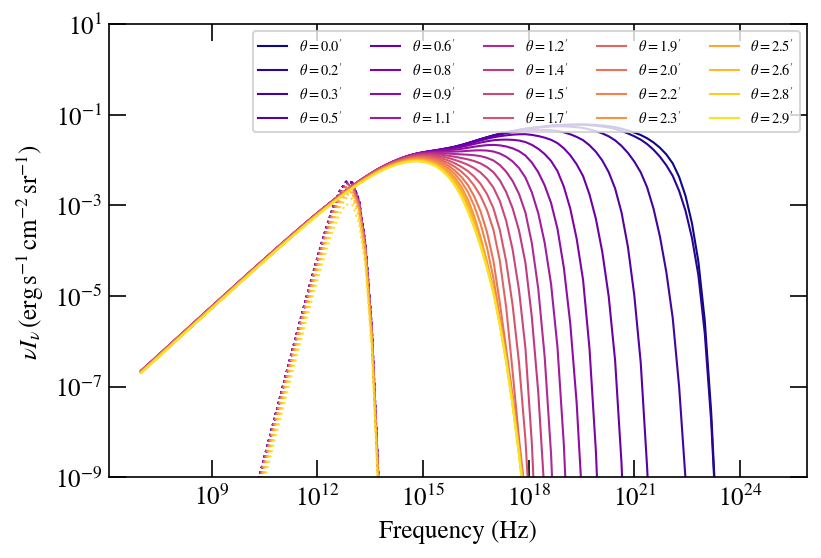

In [26]:
plt.figure(dpi=150)

for i, t in enumerate(theta_arcmin):
    if i % 5:
        continue
    plt.loglog(nu, I_nu_sync[:,i] * nu,
               color=plt.cm.plasma(i / float(theta_arcmin.size)),
               label=r"$\theta={0:.1f}^\prime$".format(t),
               lw=1
              )
    
    plt.loglog(nu, I_nu_dust[:,i] * nu,
               color=plt.cm.plasma(i / float(theta_arcmin.size)),
               #label=r"$\theta={0:.1f}^\prime$".format(t)
               ls=':', lw=1
              )
    
plt.legend(ncol=5, fontsize='x-small')
plt.ylim(1e-9, 1e1)

plt.xlabel("Frequency (Hz)")
plt.ylabel(r"$\nu I_\nu\,(\mathrm{erg}\,\mathrm{s}^{-1}\,\mathrm{cm}^{-2}\,\mathrm{sr}^{-1}$)")

Text(0, 0.5, '$I_\\nu / I_\\nu(\\theta = 0^\\circ)$')

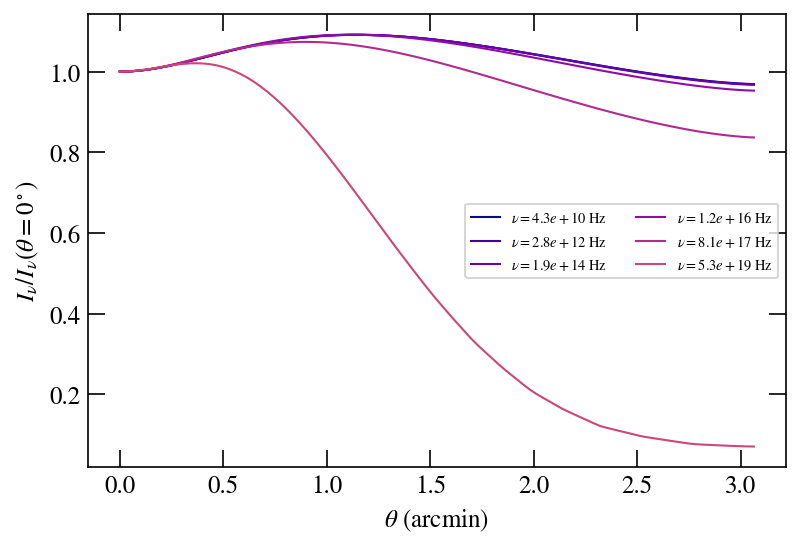

In [27]:
# intensity form factor for different frequencies

plt.figure(dpi=150)
for i, n in enumerate(nu[20:-20]):
    if i % 10:
        continue
        
    plt.plot(theta_arcmin, I_nu_sync[i, :] / I_nu_sync[i, 0],
               color=plt.cm.plasma(i / float(nu.size)),
               label=r"$\nu={0:.1e}$ Hz".format(n),
               lw=1
            )
    
plt.legend(ncol=2, fontsize='x-small', loc='center right')
plt.xlabel(r"$\theta$ (arcmin)")
plt.ylabel(r"$I_\nu / I_\nu(\theta = 0^\circ)$")

 ssc_3d.py: 513 --- DEBUG: Black body calculation in grey body function took 0.002s
 ssc_3d.py: 547 --- DEBUG: extension calculation in grey body function took 0.001s


Text(0, 0.5, '$\\nu F_\\nu\\,(\\mathrm{erg}\\,\\mathrm{s}^{-1}\\,\\mathrm{cm}^{-2}$)')

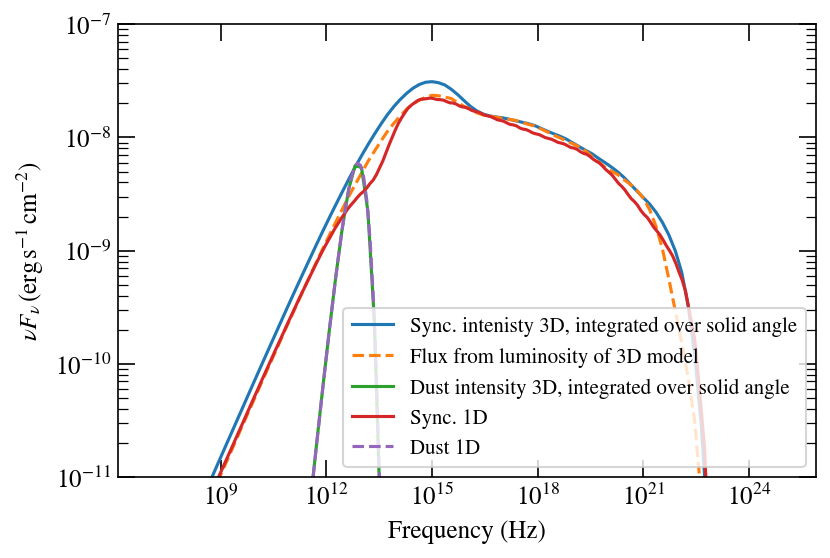

In [28]:
# plot and calculate the flux received from the whole projection of the nebula on the sky
fig=plt.figure(dpi=150)

nn, tt = np.meshgrid(nu, theta_arcmin, indexing='ij')

# synchrotron flux
# difference is roughly a factor of two, which makes sense as we're only considering 
# the flux in one direction towards us, right?
f_nu_sync = ssc.flux(nu, theta_edges=[theta_arcmin[0], theta_arcmin[-1]],
                     which='sync',
                     integration_mode='romb',
                     theta_steps=33)

# dust flux
# additional factor of 2 due to +/- theta extension of nebula disk
f_nu_dust = ssc.flux(nu, theta_edges=[theta_arcmin[0], theta_arcmin[-1]], which='dust')


plt.loglog(nu, f_nu_sync * nu, label="Sync. intenisty 3D, integrated over solid angle")

plt.loglog(nu, nu * L_nu_sync / 4. / np.pi / ssc.d ** 2.,
           ls="--", 
           label="Flux from luminosity of 3D model"
          )

plt.loglog(nu, f_nu_dust * nu, label="Dust intensity 3D, integrated over solid angle")
plt.ylim(1e-11, 1e-7)


plot_1d(luminosity=False, fig=fig, ic=False)

plt.legend()
plt.xlabel("Frequency (Hz)")
plt.ylabel(r"$\nu F_\nu\,(\mathrm{erg}\,\mathrm{s}^{-1}\,\mathrm{cm}^{-2}$)")

## IC component

Now we repeat the steps of calculating $j_\nu$, $I_\nu$, and $F_\nu$ for the IC component. Since this takes considerably longer as it involves three integrals, we use a much coarser grid for $\nu$ and $r$.  

In [40]:
# define nu and r arrays 
nu_ic = np.logspace(20., 30., 41)
r_ic_egdes = np.linspace(0., ssc.r0, 80)
r_ic = 0.5 * (r_ic_egdes[1:] + r_ic_egdes[:-1])

nni, rri = np.meshgrid(nu_ic, r_ic, indexing='ij')

# set the steps used for the integration
# these numbers yielded relatively smooth spectra
# in my tests 
# the r1_steps needs to be of the shape 2**k + 1 since romb integration is used
g_steps =91  # steps for integration over gamma
e_steps = 90  # steps for integration over energy of seed photon field
r1_steps = 33   # steps for integration over radius, see Atoyan & Aharonian (1996) Eq. 15

In [41]:
ssc.integration_mode = "numba_piecewise"  # fastest mode of integration
ssc.use_fast_interp = True  # fastest mode of interpolation

ssc.ic_sync = True
ssc.ic_dust = True
ssc.ic_cmb = True

t0 = time.time()
j_nu_ic = ssc.j_ic(nu_ic, r_ic,
                   g_steps=g_steps,
                   e_steps=e_steps,
                   r1_steps=r1_steps, 
                   integration_mode='simps'
                  )
t1 = time.time()

print(f"This took {t1 - t0:.2f}s")

 ssc_3d.py: 637 --- DEBUG: (90, 79, 33)
 ssc_3d.py: 638 --- DEBUG: Integrating using numba_piecewise
 ssc_3d.py: 646 --- DEBUG: phot_dens: time for interpolation of Sync: 0.014s, time for integration of SSC component  0.039s,  time for filling arrays 0.005s 
 ssc_3d.py: 513 --- DEBUG: Black body calculation in grey body function took 0.004s
 ssc_3d.py: 547 --- DEBUG: extension calculation in grey body function took 0.001s
 ssc_3d.py: 688 --- DEBUG: time to calculate grey body 0.010s  time for integration of dust component  0.012s
/Users/manuelmeyer/Python/crabmeyerpy/crabmeyerpy/photonfields.py:22: RuntimeWarning: overflow encountered in exp
  result = np.exp(kx) - 1.
 ssc_3d.py: 808 --- DEBUG: kernel shape for integration over photon dens energy: (41, 91, 90, 79)
 ssc_3d.py: 816 --- DEBUG: kernel shape for integration over gamma factor: (41, 91, 79)
 ssc_3d.py: 833 --- DEBUG: integration over photon dens and gamma took 12.816s


This took 15.20s


(1e-27, 1e-23)

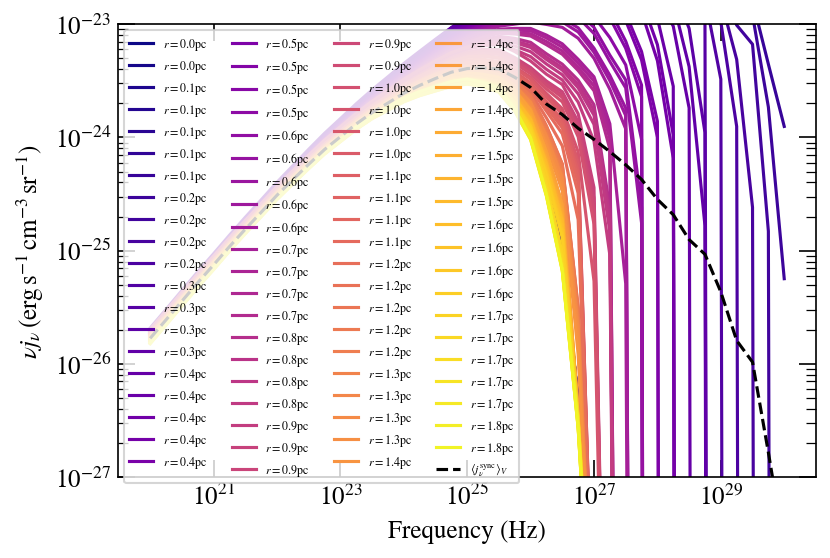

In [42]:
plt.figure(dpi=150)

for i, ri in enumerate(r_ic):
    plt.loglog(nu_ic, j_nu_ic[:,i] * nu_ic,
               color=plt.cm.plasma(i/r_ic.size),
               label='$r={0:.1f}$pc'.format(ri / kpc2cm * 1e3)
              )
    #plt.loglog(nu_ic, j_nu_ic_interp[:,i] * nu_ic,
    #           color='k',
    #           ls=':',
    #          )
    
# compute volume averaged n_el
V0 = 4. / 3. * np.pi * ssc.r0 ** 3.
j_nu_ic_avg = 4. * np.pi * simps(j_nu_ic * rri ** 2., rri) / V0

plt.loglog(nu_ic, j_nu_ic_avg * nu_ic,
           color='k',
           ls='--',
           label=r'$\langle j_\nu^\mathrm{sync} \rangle_V$'
           )

plt.legend(fontsize='xx-small', ncol=4, loc=2)
plt.xlabel("Frequency (Hz)")
plt.ylabel(r"$\nu j_\nu\,(\mathrm{erg}\,\mathrm{s}^{-1}\,\mathrm{cm}^{-3}\,\mathrm{sr}^{-1}$)")
plt.ylim(1e-27, 1e-23)

In [43]:
# Calculate the luminosity
# one factor of 4 pi from volume integral, second one from integral over 
# the solid angle. Each volume element emits isotropically.
L_nu_ic = simps(j_nu_ic * rri **2., rri, axis=1) * 4. * np.pi * 4. * np.pi

(1e+30, 1e+35)

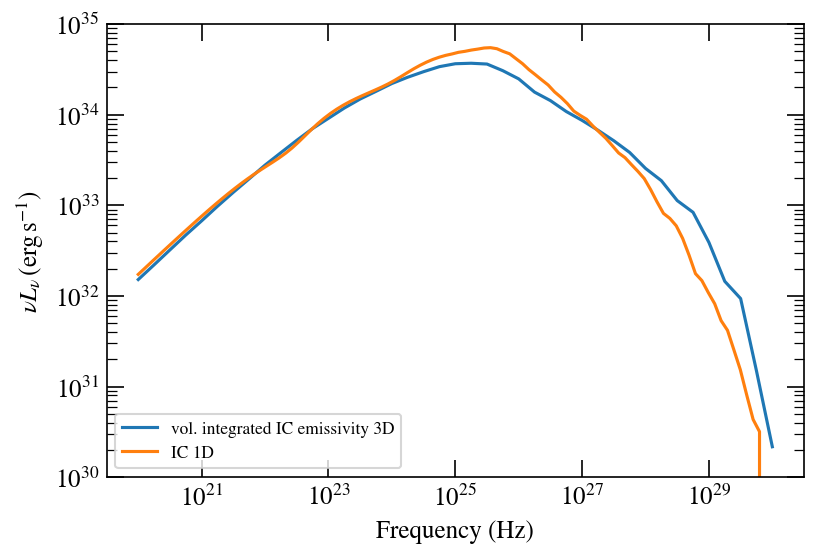

In [44]:
fig = plt.figure(dpi=150)
plt.loglog(nu_ic, nu_ic * L_nu_ic, label="vol. integrated IC emissivity 3D")

# plot the 1D spectrum for comparison
plot_1d(fig=fig, ic=True, sync=False, dust=False)
plt.legend(fontsize='small')
plt.xlabel("Frequency (Hz)")
plt.ylabel(r"$\nu L_\nu\,(\mathrm{erg}\,\mathrm{s}^{-1}$)")
plt.ylim(1e30, 1e35)

In [45]:
I_nu_ic, theta_arcmin_ic, j_ic = ssc.intensity2(nu_ic, theta=20, which='ic', integration_mode='romb', 
                                             r_steps=129, r_min=ssc.parameters['r_shock'])

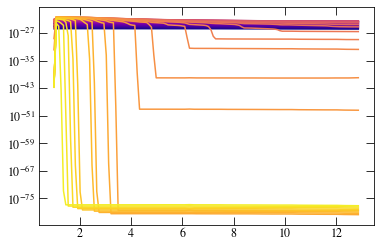

In [46]:
r_intens = np.linspace(ssc.parameters['r_shock'], ssc.r0, 129)
for i, n in enumerate(nu_ic):
    plt.semilogy(r_intens / ssc.parameters['r_shock'],
                 j_ic[i,0] * n, color=plt.cm.plasma(i / nu_ic.size))
    
#plt.ylim(1e-38, 1e-4)

#plt.ylim(1e-27, 1e-22)

Text(0, 0.5, '$\\nu I_\\nu\\,(\\mathrm{erg}\\,\\mathrm{s}^{-1}\\,\\mathrm{cm}^{-2}\\,\\mathrm{sr}^{-1}$)')

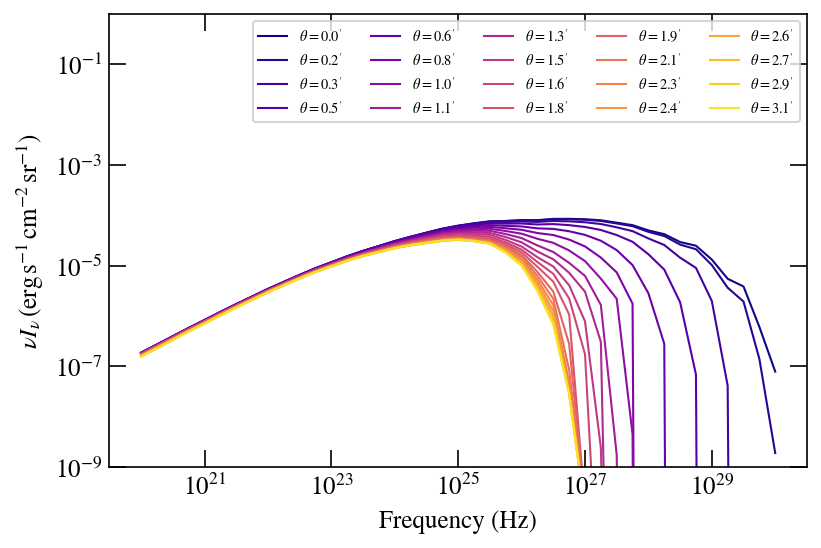

In [47]:
plt.figure(dpi=150)

for i, t in enumerate(theta_arcmin_ic):
    plt.loglog(nu_ic, I_nu_ic[:,i] * nu_ic,
               color=plt.cm.plasma(i / float(theta_arcmin_ic.size)),
               label=r"$\theta={0:.1f}^\prime$".format(t),
               lw=1
              )

    
plt.legend(ncol=5, fontsize='x-small')
plt.ylim(1e-9, 1e0)

plt.xlabel("Frequency (Hz)")
plt.ylabel(r"$\nu I_\nu\,(\mathrm{erg}\,\mathrm{s}^{-1}\,\mathrm{cm}^{-2}\,\mathrm{sr}^{-1}$)")

Text(0, 0.5, '$\\theta^2I_\\nu / I_\\nu(\\theta = 0^\\circ)$')

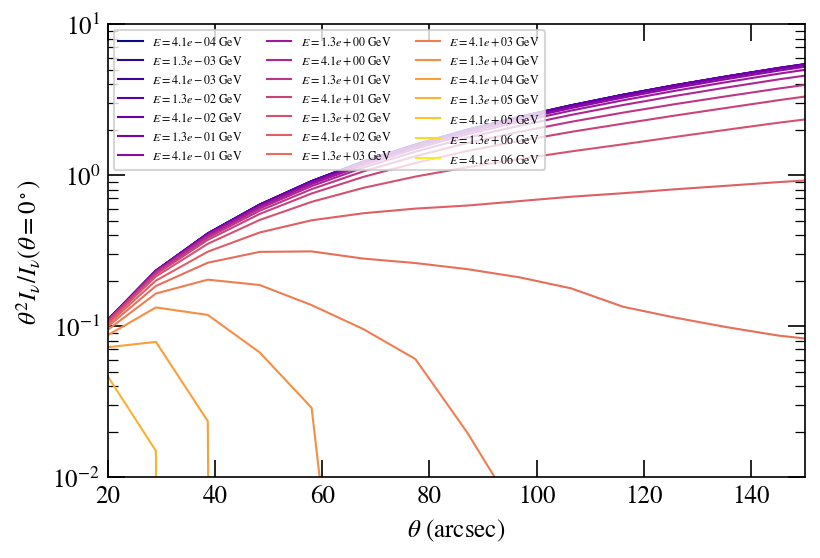

In [48]:
# intensity form factor for different frequencies

plt.figure(dpi=150)
for i, n in enumerate(nu_ic):
    if i % 2:
        continue
        
    plt.plot(theta_arcmin_ic * 60., theta_arcmin_ic**2. * I_nu_ic[i, :] / I_nu_ic[i, 0],
               color=plt.cm.plasma(i / float(nu_ic.size)),
               label=r"$E={0:.1e}$ GeV".format(n * constants.h.value * u.J.to('GeV')),
               lw=1
            )
    
plt.ylim(1e-2, 1e1)
plt.xlim(20, 150)
plt.yscale('log')
plt.legend(ncol=3, fontsize='xx-small', loc=2)
plt.xlabel(r"$\theta$ (arcsec)")
plt.ylabel(r"$\theta^2I_\nu / I_\nu(\theta = 0^\circ)$")

In [49]:
f_nu_ic = ssc.flux(nu_ic, theta_edges=[theta_arcmin[0], theta_arcmin[-1]],
                   which='ic',
                   integration_mode='romb',
                   r_steps=65,
                   theta_steps=65)

(1e-13, 3e-10)

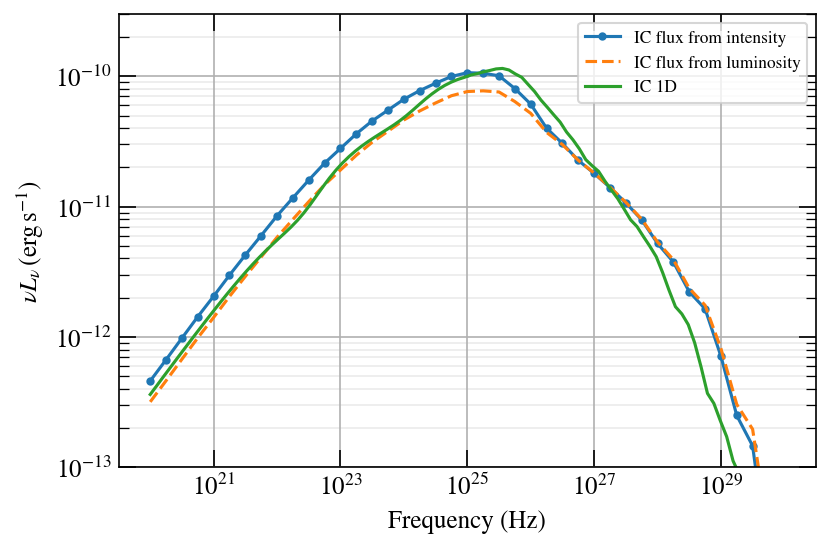

In [50]:
fig = plt.figure(dpi=150)
plt.loglog(nu_ic, nu_ic * f_nu_ic, label="IC flux from intensity", marker='.')

plt.loglog(nu_ic, nu_ic * L_nu_ic / 4. / np.pi / ssc.d ** 2.,
           label="IC flux from luminosity", ls='--')
# plot the 1D spectrum for comparison
plot_1d(fig=fig, ic=True, sync=False, dust=False, luminosity=False)
plt.legend(fontsize='small')
plt.xlabel("Frequency (Hz)")
plt.ylabel(r"$\nu L_\nu\,(\mathrm{erg}\,\mathrm{s}^{-1}$)")
plt.grid()
plt.grid(which='minor', lw=0.2)
plt.ylim(1e-13, 3e-10)


## Full SED pass

Here, we time how long it takes to calculate the whole SED for one set of parameters.

In [58]:
%%timeit

# define r and nu arrays
r = np.linspace(ssc.parameters['r_shock'], ssc.r0, 10)
nu_sync = np.logspace(7.,25.,200)

# Calculate and interpolate the synchrotron spectrum
ssc.use_fast_interp = True  # use a 2D interpolation routine using numba
ssc.interp_sync_init(r_min=r.min(), r_max=r.max())

# Calculate the intensities along the line of sight
I_nu_sync, _, _ = ssc.intensity2(nu, theta=20)
I_nu_dust, _, _ = ssc.intensity2(nu, theta=20, which='dust')

# Calculate the IC emissivity
nu_ic = np.logspace(20., 30., 31)
r_ic_egdes = np.linspace(ssc.parameters['r_shock'], ssc.r0, 80)
r_ic = 0.5 * (r_ic_egdes[1:] + r_ic_egdes[:-1])

g_steps = 91  # steps for integration over gamma
e_steps = 92  # steps for integration over energy of seed photon field
r1_steps = 33   # steps for integration over radius, see Atoyan & Aharonian (1996) Eq. 15

ssc.integration_mode = 'numba_piecewise'  # fastest option
ssc.use_fast_interp = True  # fastest mode of interpolation

j_nu_ic = ssc.j_ic(nu_ic, r_ic,
                   g_steps=g_steps,
                   e_steps=e_steps,
                   r1_steps=r1_steps)

# calculate the intensity along the line of sight
I_nu_ic, theta_arcmin_ic, j_ic = ssc.intensity2(nu_ic, theta=20, which='ic')

# calculate the flux for different theta
f_nu_ic = ssc.flux(nu_ic, theta_edges=[theta_arcmin[0], theta_arcmin[-1]],
                   which='ic',
                   integration_mode='romb',
                   r_steps=65,
                   theta_steps=65)

 ssc_3d.py: 513 --- DEBUG: Black body calculation in grey body function took 0.003s
 ssc_3d.py: 547 --- DEBUG: extension calculation in grey body function took 0.001s
 ssc_3d.py: 637 --- DEBUG: (92, 79, 33)
 ssc_3d.py: 638 --- DEBUG: Integrating using numba_piecewise
 ssc_3d.py: 646 --- DEBUG: phot_dens: time for interpolation of Sync: 0.013s, time for integration of SSC component  0.012s,  time for filling arrays 0.002s 
 ssc_3d.py: 513 --- DEBUG: Black body calculation in grey body function took 0.004s
 ssc_3d.py: 547 --- DEBUG: extension calculation in grey body function took 0.001s
 ssc_3d.py: 688 --- DEBUG: time to calculate grey body 0.010s  time for integration of dust component  0.013s
 ssc_3d.py: 808 --- DEBUG: kernel shape for integration over photon dens energy: (31, 91, 92, 79)
 ssc_3d.py: 816 --- DEBUG: kernel shape for integration over gamma factor: (31, 91, 79)
 ssc_3d.py: 833 --- DEBUG: integration over photon dens and gamma took 10.403s
 ssc_3d.py: 513 --- DEBUG: Black

30.1 s ± 950 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
